In [1]:
import sys
sys.path.append('..')

In [2]:
from AutoPos.Model import OhePosModel
from mySVM.model import SVM

In [3]:
import numpy as np

In [4]:
enzyme_aligned_file = '../Data/Modified-Enzyme-Alignment.txt'

In [5]:
from sklearn.feature_selection import chi2

In [6]:
import helper
X,y,enz_name = helper.parseEnzymeFile(enzyme_aligned_file)

In [7]:
np.random.seed(437)
teidx,tridx = helper.modified_split(enz_name)

In [8]:
ohepos = OhePosModel(enzyme_aligned_file,chi2,None,50,training=tridx)

In [9]:
def createEncodedArraywithGAA(X,bestpos):
    X = np.array(list(map(list,X)))
    AAs = ['-','A','C','D','E','F','G','H','I','K','L', #11
            'M','N','P','Q','R','S','T','V','W','X','Y'] #22
    OHE_dict = dict(zip(AAs,range(len(AAs))))
    GAAmap = {'G':'g1','A':'g1','V':'g1','L':'g1','M':'g1','I':'g1','F':'g2','Y':'g2','W':'g2',
                       'K':'g3','R':'g3','H':'g3', 'D':'g4', 'E':'g4','S':'g5','T':'g5','C':'g5','P':'g5',
                       'N':'g5','Q':'g5','X':'g6','-':'g6'}
    GAAs = sorted(set(GAAmap.values()))
    for i,gaaval in enumerate(GAAs):
        OHE_dict[gaaval] = i+len(AAs)
    X_enc = np.zeros((X.shape[0],len(bestpos)*(len(AAs)+len(GAAs))))
    
    
    for pos_i,pos in enumerate(bestpos):
        for x_i,x in enumerate(X):
            
            #get the value of the AA
            AAval = x[pos]
            GAAval = GAAmap[AAval]
            #get the column index that will be 1
            y_i = pos_i*(len(AAs)+len(GAAs)) + OHE_dict[AAval]
            y_i_gaa = pos_i*(len(AAs)+len(GAAs)) + OHE_dict[GAAval]
            X_enc[x_i,y_i] = 1
            X_enc[x_i,y_i_gaa] = 1
    return X_enc

In [10]:
def createEncodedArray(X,bestpos):
    X = np.array(list(map(list,X)))
    AAs = ['-','A','C','D','E','F','G','H','I','K','L', #11
            'M','N','P','Q','R','S','T','V','W','X','Y'] #22
    OHE_dict = dict(zip(AAs,range(len(AAs))))
    X_enc = np.zeros((X.shape[0],len(bestpos)*len(AAs)))
    
    
    for pos_i,pos in enumerate(bestpos):
        for x_i,x in enumerate(X):
            
            #get the value of the AA
            AAval = x[pos]
            #get the column index that will be 1
            y_i = pos_i*len(AAs) + OHE_dict[AAval]
            y_i_gaa = pos_i*len(AAs)
            X_enc[x_i,y_i] = 1
    return X_enc

In [11]:
X_enc = createEncodedArray(X,ohepos.BestPositions)

In [12]:
X_enc.shape

(116, 1100)

In [13]:
Xtrain,Xtest,ytrain,ytest = X_enc[tridx],X_enc[teidx],y[tridx],y[teidx]

In [14]:
svm = SVM(Xtrain,Xtest,ytrain,ytest)

-----Initial Model Evaluation-----
-----Training Accuracy:0.8390804597701149-----
-----Testing Accuracy:0.6296296296296297-----


In [15]:
random_pos = np.random.randint(0,len(X[0]),size=50)

In [16]:
X_enc_random = createEncodedArray(X,random_pos)

In [17]:
Xtrainr,Xtestr= X_enc_random[tridx],X_enc_random[teidx]

In [18]:
svm_random = SVM(Xtrainr,Xtestr,ytrain,ytest,regC=20)

-----Initial Model Evaluation-----
-----Training Accuracy:0.7816091954022989-----
-----Testing Accuracy:0.48148148148148145-----


In [19]:
def multiprocess_func(randomseed):
    np.random.seed(randomseed)
    teidx,tridx = helper.modified_split(enz_name)
    n_positions = 50
    ohepos = OhePosModel(enzyme_aligned_file,chi2,None,n_positions,training=tridx)
    random_pos = np.random.randint(0,len(X[0]),size=n_positions)
    X_enc = createEncodedArray(X,ohepos.BestPositions)
    X_enc_random = createEncodedArray(X,random_pos)
    Xtrain,Xtest,ytrain,ytest = X_enc[tridx],X_enc[teidx],y[tridx],y[teidx]
    Xtrainr,Xtestr= X_enc_random[tridx],X_enc_random[teidx]
    svm = SVM(Xtrain,Xtest,ytrain,ytest,random_seed=randomseed,kern='rbf',pca_comp=40,regC=20,verbose=False)
    svm_random = SVM(Xtrainr,Xtestr,ytrain,ytest,random_seed=randomseed,kern='rbf',pca_comp=40,regC=20,verbose=False)
    return svm.acc_test,svm_random.acc_test
    
    

In [20]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

In [21]:
%%time
accs = pool.map(multiprocess_func,[i for i in range(10000)])

CPU times: user 133 ms, sys: 43 ms, total: 176 ms
Wall time: 1min 6s


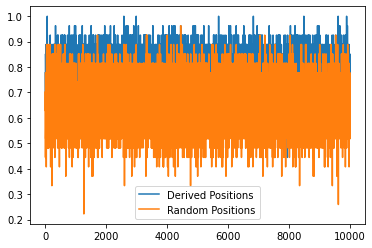

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(accs)),accs)
plt.legend(['Derived Positions','Random Positions'])

In [23]:
accs_derived = [a[0] for a in accs]
accs_random = [a[1] for a in accs]

print('*'*5+'Comparing Means'+'*'*5)
print(np.mean(accs_derived),np.mean(accs_random))
print('*'*5+'Comparing Worst Case Accuracy'+'*'*5)
print(min(accs_derived),min(accs_random))
print('*'*5+'Comparing Standard Deviation'+'*'*5)
print(np.std(accs_derived),np.std(accs_random))

*****Comparing Means*****
0.7675037037037037 0.6578777777777778
*****Comparing Worst Case Accuracy*****
0.4444444444444444 0.2222222222222222
*****Comparing Standard Deviation*****
0.07818104661222383 0.08792524501280854


In [24]:
win_cases = [True if a1>=a2 else False for a1,a2 in accs ]

In [25]:
sum(win_cases)

9200